In [1]:
from tqdm import tqdm

In [2]:
from scipy.io import wavfile

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [4]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from torch import nn 
from python_speech_features import mfcc
import torch.nn.functional as F
import time

In [5]:
import torch

In [6]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
class StatsPooling(nn.Module):
    def __init__(self):
        super(StatsPooling,self).__init__()

    def forward(self,varient_length_tensor):
        mean = varient_length_tensor.mean(dim=2)
        std = varient_length_tensor.std(dim=2)
        return torch.cat((mean,std),dim=1)

class Xvector(nn.Module):
    def __init__(self):
        super(Xvector, self).__init__()
        context = [-2,2]
        input_dim = 24
        output_dim = 512
        self.net1 = TDNN(context, input_dim, output_dim, full_context=True)

        context = [-2,0,2]
        input_dim = 512
        output_dim = 512
        self.net2 = TDNN(context, input_dim, output_dim, full_context=False)

        context = [-3,0,3]
        input_dim = 512
        output_dim = 512
        self.net3 = TDNN(context, input_dim, output_dim, full_context=False)

        context = [0]
        input_dim = 512
        output_dim = 512
        self.net4 = TDNN(context, input_dim, output_dim, full_context=True)

        context = [0]
        input_dim = 512
        output_dim = 1500
        self.net5 = TDNN(context, input_dim, output_dim, full_context=True)

        self.SP = StatsPooling()
        self.hidden1 = nn.Linear(3000,512).double()
        self.hidden2 = nn.Linear(512,512).double()

        self.Final = nn.Linear(512,len(clases)).double()
        
    def forward(self,x):
        x = self.net1(x)
        x = self.net2(x)
        x = self.net3(x)
        x = self.net4(x)
        x = self.net5(x)
        x = self.SP(x).double()
        x = F.relu(self.hidden1(x))
        embedding = x 
        x = F.relu(self.hidden2(x))
        return self.Final(x) ,embedding
    

In [7]:
net_xvec = torch.load("model")
net_xvec.cuda()

Xvector(
  (net1): TDNN(
    (temporal_conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
  )
  (net2): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
  )
  (net3): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
  )
  (net4): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  )
  (net5): TDNN(
    (temporal_conv): Conv1d(512, 1500, kernel_size=(1,), stride=(1,))
  )
  (SP): StatsPooling()
  (hidden1): Linear(in_features=3000, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=512, bias=True)
  (Final): Linear(in_features=512, out_features=4, bias=True)
)

In [8]:
wav_path = "andrew.wav"
max_total_context_test = 400
_min,_max = float('inf'),-float('inf')
X_test = []
rate, wav = wavfile.read(wav_path)
for chunked_wav in tqdm(list(chunks(wav,int(len(wav)/40)))):
    X_sample = mfcc(chunked_wav,samplerate= rate,numcep=24
           ,nfilt=26,nfft=1024)
    _min = min(np.amin(X_sample),_min)
    _max = max(np.amax(X_sample),_max)
    for chunked_X_sample in list(chunks(X_sample,max_total_context_test)):
            if len(chunked_X_sample) == max_total_context_test:
                X_test.append(chunked_X_sample)
X_test = (X_test - _min) / (_max-_min)


100%|██████████| 41/41 [00:08<00:00,  4.85it/s]


In [9]:
ng_outout = net_xvec(torch.tensor(X_test[200:230]).cuda().transpose(1,2).float())[1]

In [10]:
np_ng_output = ng_outout.cpu().detach().numpy()

In [12]:
xvecs_collection = {0:[],1:[],2:[],3:[]}

In [13]:
with open('X_data_16_06.pkl','rb') as f:
    X,y =  pickle.load(f)

trainloader = torch.utils.data.DataLoader(list(zip(X,y)), shuffle=True, batch_size=5)

In [14]:

for i, data in enumerate(trainloader, 0):
    a = time.time()
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.cuda().transpose(1,2).float(), labels.cuda()
    output= net_xvec(inputs)[1]
    for j,out in enumerate(output):
        index_to_append = int(torch.argmax(labels[j]))
        xvecs_collection[index_to_append].append(out.detach().cpu().numpy())
        print ('appending to {}'.format(index_to_append))

appending to 1
appending to 0
appending to 0
appending to 3
appending to 1
appending to 1
appending to 3
appending to 1
appending to 0
appending to 0
appending to 0
appending to 1
appending to 3
appending to 1
appending to 3
appending to 1
appending to 0
appending to 3
appending to 0
appending to 2
appending to 1
appending to 3
appending to 1
appending to 3
appending to 1
appending to 0
appending to 1
appending to 3
appending to 3
appending to 0
appending to 3
appending to 1
appending to 2
appending to 3
appending to 1
appending to 0
appending to 3
appending to 0
appending to 0
appending to 3
appending to 0
appending to 2
appending to 1
appending to 1
appending to 0
appending to 3
appending to 2
appending to 3
appending to 3
appending to 3
appending to 1
appending to 2
appending to 1
appending to 2
appending to 0
appending to 1
appending to 3
appending to 0
appending to 1
appending to 1
appending to 1
appending to 1
appending to 3
appending to 1
appending to 0
appending to 1
appending 

appending to 1
appending to 3
appending to 0
appending to 0
appending to 3
appending to 1
appending to 0
appending to 1
appending to 3
appending to 2
appending to 3
appending to 0
appending to 0
appending to 0
appending to 3
appending to 3
appending to 0
appending to 3
appending to 3
appending to 0
appending to 1
appending to 3
appending to 0
appending to 0
appending to 3
appending to 1
appending to 3
appending to 0
appending to 0
appending to 3
appending to 3
appending to 0
appending to 0
appending to 0
appending to 3
appending to 3
appending to 1
appending to 3
appending to 0
appending to 1
appending to 0
appending to 3
appending to 1
appending to 1
appending to 3
appending to 3
appending to 0
appending to 3
appending to 3
appending to 0
appending to 0
appending to 3
appending to 1
appending to 0
appending to 1
appending to 3
appending to 0
appending to 1
appending to 1
appending to 2
appending to 0
appending to 1
appending to 3
appending to 3
appending to 3
appending to 0
appending 

appending to 3
appending to 1
appending to 0
appending to 2
appending to 1
appending to 1
appending to 1
appending to 0
appending to 1
appending to 0
appending to 3
appending to 1
appending to 1
appending to 0
appending to 0
appending to 1
appending to 1
appending to 1
appending to 3
appending to 3
appending to 3
appending to 3
appending to 0
appending to 1
appending to 2
appending to 3
appending to 0
appending to 3
appending to 0
appending to 1
appending to 1
appending to 3
appending to 1
appending to 1
appending to 3
appending to 1
appending to 3
appending to 0
appending to 2
appending to 3
appending to 3
appending to 0
appending to 1
appending to 0
appending to 3
appending to 3
appending to 3
appending to 0
appending to 1
appending to 3
appending to 0
appending to 0
appending to 3
appending to 1
appending to 1
appending to 0
appending to 1
appending to 2
appending to 3
appending to 3
appending to 3
appending to 3
appending to 1
appending to 3
appending to 1
appending to 1
appending 

In [15]:
# with open(r"D:\ml+dl+dsp\xvector\celebs_xvectors",'rb') as f:
#     xvecs_collection= pickle.load(f)

In [16]:
clases = ['Trump','Macron','Gaga','Clinton','Andrew_ng']

In [17]:
lda = LDA(n_components=3)

In [18]:
X = []
y = []
for class_num in range(len(xvecs_collection)):
    for item in xvecs_collection[class_num]:
        X.append(item)
        y.append(class_num)

In [19]:
## Add untrained andrew ng to the test set
for item in np_ng_output:
    X.append(item)
    y.append(4)

In [20]:
lda_model = lda.fit(X,y)

In [21]:
transformed_X= lda_model.transform(X)

In [22]:
clases_dict = {0:[],1:[],2:[],3:[],4:[]}

In [23]:
for i,x in enumerate(transformed_X):
    clases_dict[y[i]].append(x)

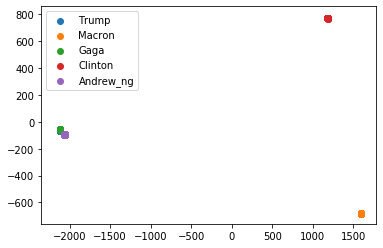

In [24]:
# for index in clases_dict:
#     plt.scatter(np.array(clases_dict[index])[:,0],np.array(clases_dict[index])[:,1])
# plt.legend(clases)

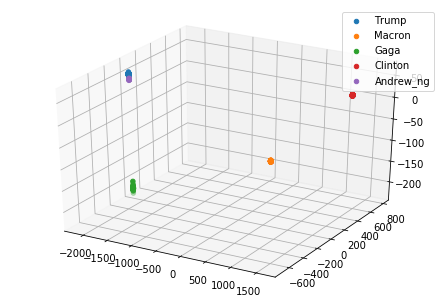

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
for index in clases_dict:
    ax.scatter(np.array(clases_dict[index])[:,0],np.array(clases_dict[index])[:,1],np.array(clases_dict[index])[:,2])
plt.legend(clases)